# Get 6C Data for Event

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client

from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

config['path_to_outdata'] = data_path+"romy_events/data/"

config['path_to_sds'] = archive_path+"romy_archive/"
config['path_to_fur'] = bay_path+"mseed_online/archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

## BSPF coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

config['submask'] = ""


## Eventtime
config['eventtime'] = obs.UTCDateTime("2023-10-25 13:40:00")

# config['event_name'] = "Italy"
# config['tbeg'] = obs.UTCDateTime("2023-10-25 13:45:00")
# config['tend'] = obs.UTCDateTime("2023-10-25 13:50:00")

# config['event_name'] = "Morocco"
# config['tbeg'] = obs.UTCDateTime("2023-09-08 22:00")
# config['tend'] = obs.UTCDateTime("2023-09-08 23:00")

# config['tbeg'] = obs.UTCDateTime("2023-09-08 22:30")
# config['tend'] = obs.UTCDateTime("2023-09-08 23:30")

config['event_name'] = "Alaska"
config['tbeg'] = obs.UTCDateTime("2018-01-23 09:31:40")
config['tend'] = obs.UTCDateTime("2018-01-23 11:00:00")

config['event_name'] = "PNG"
config['tbeg'] = obs.UTCDateTime("2019-05-14 12:58:26")
config['tend'] = obs.UTCDateTime("2019-05-14 14:58:26")


config['fmin'] = 0.01
config['fmax'] = 10

## Load Data

#### Find event in catalog

In [4]:
event = Client("IRIS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=4.0)
event = event[0]

#### Load inventory

In [5]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")
# seis_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_DROMY")
seis_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.GR_FUR")

In [6]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJW", config['tbeg']-1, config['tend']+1)

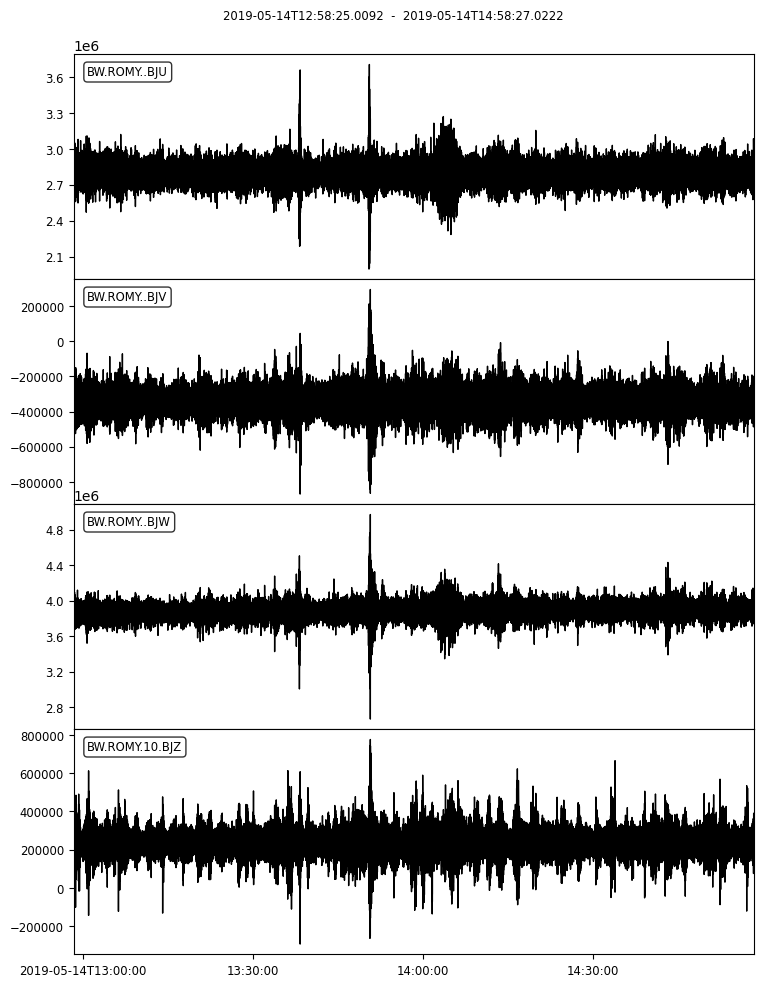

In [7]:
st0.plot(equal_scale=False);

In [8]:
acc = __read_sds(config['path_to_fur'], "GR.FUR..BH*", config['tbeg']-1, config['tend']+1)

acc.remove_response(seis_inv, output="ACC")

acc.detrend("demean")

3 Trace(s) in Stream:
GR.FUR..BHE | 2019-05-14T12:58:24.989999Z - 2019-05-14T14:58:26.989999Z | 20.0 Hz, 144041 samples
GR.FUR..BHN | 2019-05-14T12:58:24.990000Z - 2019-05-14T14:58:26.990000Z | 20.0 Hz, 144041 samples
GR.FUR..BHZ | 2019-05-14T12:58:24.990000Z - 2019-05-14T14:58:26.990000Z | 20.0 Hz, 144041 samples

3 Trace(s) in Stream:
GR.FUR..BHE | 2019-05-14T12:58:24.989999Z - 2019-05-14T14:58:26.989999Z | 20.0 Hz, 144041 samples
GR.FUR..BHN | 2019-05-14T12:58:24.990000Z - 2019-05-14T14:58:26.990000Z | 20.0 Hz, 144041 samples
GR.FUR..BHZ | 2019-05-14T12:58:24.990000Z - 2019-05-14T14:58:26.990000Z | 20.0 Hz, 144041 samples

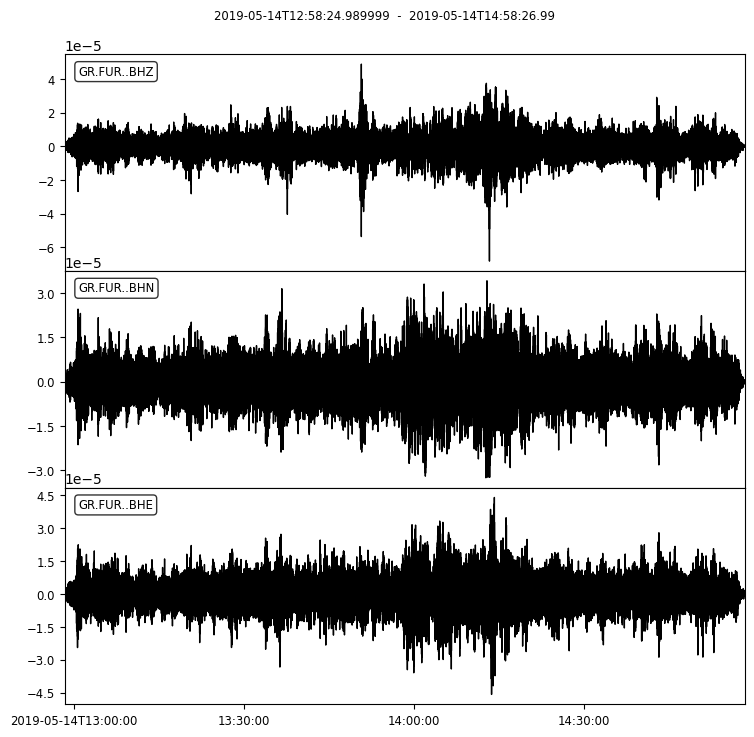

In [9]:
acc.plot(equal_scale=False);

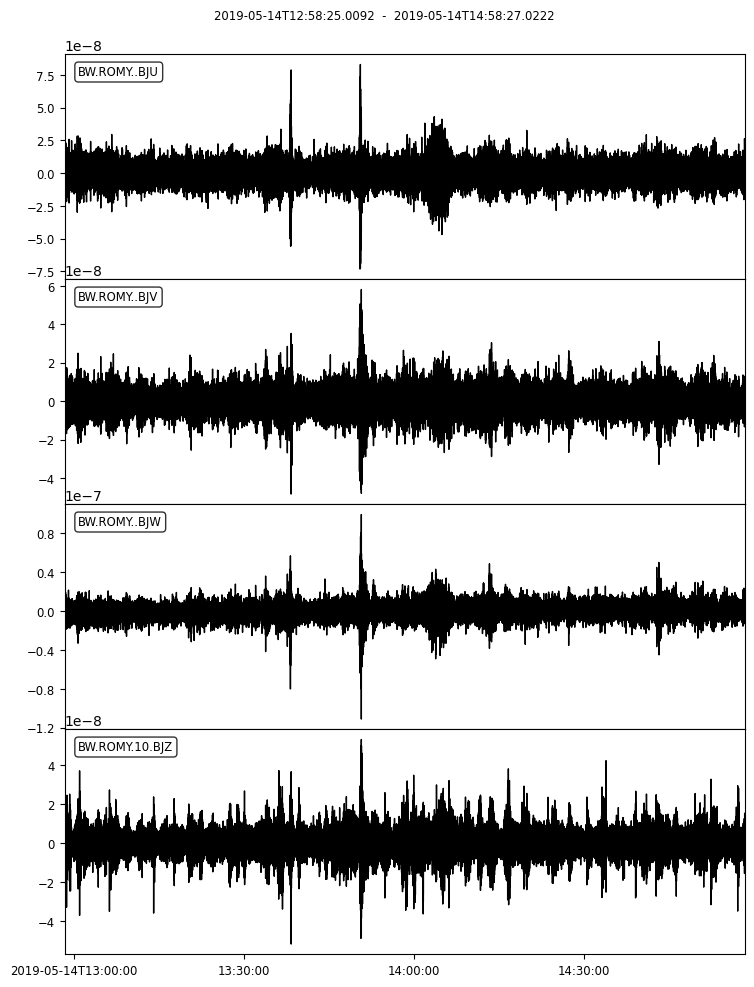

In [10]:
st = st0.copy()

st.remove_sensitivity(romy_inv)

st.detrend("demean")
# st.taper(0.1)

# st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

st.plot(equal_scale=False);

In [11]:
# st = st.rotate(method="->ZNE", inventory=romy_inv)

ori_z = romy_inv.get_orientation("BW.ROMY.10.BJZ")
ori_u = romy_inv.get_orientation("BW.ROMY..BJU")
ori_v = romy_inv.get_orientation("BW.ROMY..BJV")
ori_w = romy_inv.get_orientation("BW.ROMY..BJW")

romy_z = st.select(channel="*Z")[0].data
romy_u = st.select(channel="*U")[0].data
romy_v = st.select(channel="*V")[0].data
romy_w = st.select(channel="*W")[0].data

from obspy.signal.rotate import rotate2zne

# rotating using only two tilted rings
romy_z, romy_n, romy_e =rotate2zne(
                                   romy_z, ori_z['azimuth'], ori_z['dip'],
                                   romy_u, ori_u['azimuth'], ori_u['dip'],
                                   romy_v, ori_v['azimuth'], ori_v['dip'],
                                   inverse=False
                                  )

st_two = st.copy()

# st_new.select(channel="*Z")[0].data = romy_z
st_two.select(channel="*U")[0].data = romy_n
st_two.select(channel="*V")[0].data = romy_e
st_two.select(channel="*W")[0].data = romy_z

# rename channels
st_two.select(channel="*U")[0].stats.channel = "BJN"
st_two.select(channel="*V")[0].stats.channel = "BJE"
st_two.select(channel="*W")[0].stats.channel = "BJZ"


## rotating using all tilted rings
romy_z, romy_n, romy_e =rotate2zne(
                                   romy_u, ori_u['azimuth'], ori_u['dip'],
                                   romy_v, ori_v['azimuth'], ori_v['dip'],
                                   romy_w, ori_w['azimuth'], ori_w['dip'],
                                   inverse=False
                                  )
st_all = st.copy()

# st_new.select(channel="*Z")[0].data = romy_z
st_all.select(channel="*U")[0].data = romy_n
st_all.select(channel="*V")[0].data = romy_e
st_all.select(channel="*W")[0].data = romy_z

# rename channels
st_all.select(channel="*U")[0].stats.channel = "BJN"
st_all.select(channel="*V")[0].stats.channel = "BJE"
st_all.select(channel="*W")[0].stats.channel = "BJZ"


In [12]:
# st_all.plot(equal_scale=False);

## Compare Waveforms

In [13]:
def __makeplot_waveform_comparison(st1, st2):

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(st1.select(channel="*Z")[0].times(), st1.select(channel="*Z")[0].data*rot_scaling, lw=lw, label="Z", color="darkred", ls="-", zorder=3)
    ax[0].plot(st2.select(channel="*Z")[0].times(), st2.select(channel="*Z")[0].data*rot_scaling, lw=lw, label="Z", color="black", zorder=2)

    ax[1].plot(st1.select(channel="*U")[0].times(), st1.select(channel="*U")[0].data*rot_scaling, lw=lw, label="U", color="darkred", ls="-", zorder=3)
    ax[1].plot(st2.select(channel="*N")[0].times(), st2.select(channel="*N")[0].data*rot_scaling, lw=lw, label="N", color="black", zorder=2)

    ax[2].plot(st1.select(channel="*V")[0].times(), st1.select(channel="*V")[0].data*rot_scaling, lw=lw, label="V", color="darkred", ls="-", zorder=3)
    ax[2].plot(st2.select(channel="*E")[0].times(), st2.select(channel="*E")[0].data*rot_scaling, lw=lw, label="E", color="black", zorder=2)

    ax00 = ax[0].twinx()
    diff_Z = ( abs(st1.select(channel="*Z")[0].data - st2.select(channel="*Z")[0].data)*rot_scaling )
    ax00.fill_between(st2.select(channel="*Z")[0].times(), diff_Z, color="grey", alpha=0.5, zorder=1)
    ax00.set_ylim(-1, 10)

    ax11 = ax[1].twinx()
    diff_N = ( abs(st1.select(channel="*U")[0].data - st2.select(channel="*N")[0].data)*rot_scaling )
    ax11.fill_between(st2.select(channel="*N")[0].times(), diff_N, color="grey", alpha=0.5, zorder=1)
    ax11.set_ylim(-1, 10)

    ax22 = ax[2].twinx()
    diff_E = ( abs(st1.select(channel="*V")[0].data - st2.select(channel="*E")[0].data)*rot_scaling )
    ax22.fill_between(st2.select(channel="*E")[0].times(), diff_E, color="grey", alpha=0.5, zorder=1)
    ax22.set_ylim(-1, 10)

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel(r"$\Omega$ (nrad/s)")

    ax[2].set_xlabel("Time (s)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

In [14]:
# config['fmin'] = 0.01
# config['fmax'] = 0.1

# st_cp = st.copy()
# st_cp = st_cp.detrend("demean");
# st_cp = st_cp.taper(0.1);
# st_cp = st_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);
# st_cp.trim(config['tbeg']+600, config['tend'])

# st_rot_cp = st_new.copy()
# st_rot_cp = st_rot_cp.detrend("demean");
# st_rot_cp = st_rot_cp.taper(0.1);
# st_rot_cp = st_rot_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

# st_rot_cp.trim(config['tbeg']+600, config['tend'])



# fig = __makeplot_waveform_comparison(st_cp, st_rot_cp)

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight');

In [15]:
def __makeplot_waveform_comparison2(st1, st2):

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(st1.select(location="10", channel="*Z")[0].times(), st1.select(location="10", channel="*Z")[0].data*rot_scaling,
               lw=lw, label="10.BJZ", color="green", ls="-", zorder=3)

    ax[0].plot(st1.select(location="", channel="*Z")[0].times(), st1.select(location="", channel="*Z")[0].data*rot_scaling,
               lw=lw, label="Z (UVW)", color="darkred", ls="-", zorder=3)
    ax[0].plot(st2.select(location="", channel="*Z")[0].times(), st2.select(location="", channel="*Z")[0].data*rot_scaling,
               lw=lw, label="Z (UV)", color="black", zorder=2)

    ax[1].plot(st1.select(channel="*N")[0].times(), st1.select(channel="*N")[0].data*rot_scaling,
               lw=lw, label="N (UVW)", color="darkred", ls="-", zorder=3)
    ax[1].plot(st2.select(channel="*N")[0].times(), st2.select(channel="*N")[0].data*rot_scaling,
               lw=lw, label="N (UV)", color="black", zorder=2)

    ax[2].plot(st1.select(channel="*E")[0].times(), st1.select(channel="*E")[0].data*rot_scaling,
               lw=lw, label="E (UVW)", color="darkred", ls="-", zorder=3)
    ax[2].plot(st2.select(channel="*E")[0].times(), st2.select(channel="*E")[0].data*rot_scaling,
               lw=lw, label="E (UV)", color="black", zorder=2)

    ax00 = ax[0].twinx()
    diff_Z = ( abs(st1.select(channel="*Z")[0].data - st2.select(channel="*Z")[0].data)*rot_scaling )
    ax00.fill_between(st2.select(channel="*Z")[0].times(), diff_Z, color="grey", alpha=0.5, zorder=1)
    ax00.set_ylim(-1, 20)

    ax11 = ax[1].twinx()
    diff_N = ( abs(st1.select(channel="*N")[0].data - st2.select(channel="*N")[0].data)*rot_scaling )
    ax11.fill_between(st2.select(channel="*N")[0].times(), diff_N, color="grey", alpha=0.5, zorder=1)
    ax11.set_ylim(-1, 20)

    ax22 = ax[2].twinx()
    diff_E = ( abs(st1.select(channel="*E")[0].data - st2.select(channel="*E")[0].data)*rot_scaling )
    ax22.fill_between(st2.select(channel="*E")[0].times(), diff_E, color="grey", alpha=0.5, zorder=1)
    ax22.set_ylim(-1, 20)

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel(r"$\Omega$ (nrad/s)")

    ax[2].set_xlabel("Time (s)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

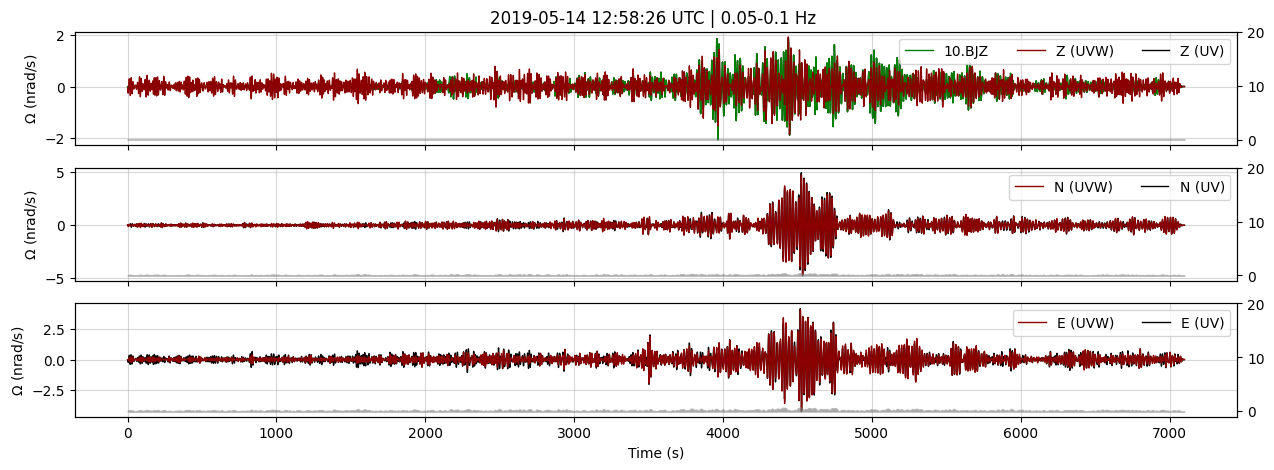

In [16]:
config['fmin'] = 0.05
config['fmax'] = 0.1

st1 = st_all.copy()
st1 = st1.detrend("demean");
st1 = st1.taper(0.01);
st1 = st1.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);
st1 = st1.trim(config['tbeg']+100, config['tend'])

st2 = st_two.copy()
st2 = st2.detrend("demean");
st2 = st2.taper(0.01);
st2 = st2.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);
st2 = st2.trim(config['tbeg']+100, config['tend'])



fig = __makeplot_waveform_comparison2(st1, st2)

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight');


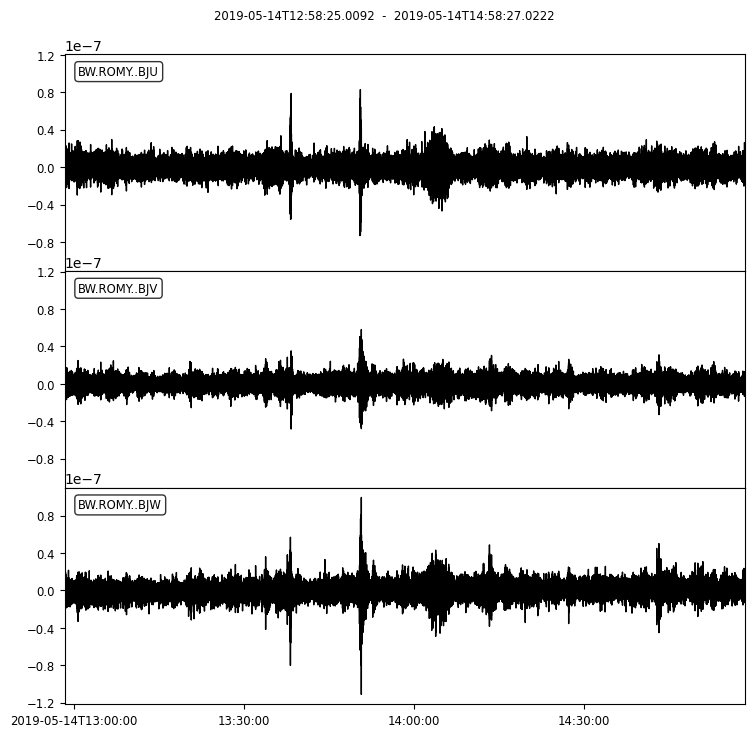

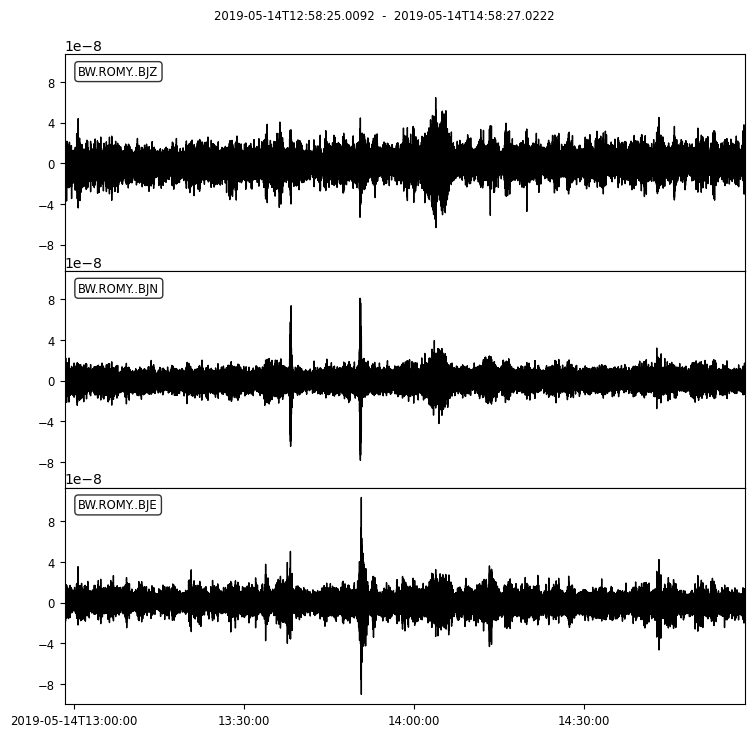

In [17]:
## rotating using all tilted rings
stx = st.copy()

stx.remove(st.select(location="10")[0])

stx.plot();

stx = stx.rotate(method="->ZNE", inventory=romy_inv, components="UVW")

# st_all = st.copy()

# # st_new.select(channel="*Z")[0].data = romy_z
# st_all.select(channel="*U")[0].data = romy_n
# st_all.select(channel="*V")[0].data = romy_e
# st_all.select(channel="*W")[0].data = romy_z

# # rename channels
# st_all.select(channel="*U")[0].stats.channel = "BJN"
# st_all.select(channel="*V")[0].stats.channel = "BJE"
# st_all.select(channel="*W")[0].stats.channel = "BJZ"

stx.plot();

## Compare Z components

In [18]:
def __makeplot_waveform_comparison3(st1, st2):

    fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(st1.select(location="10", channel="*Z")[0].times(), st1.select(location="10", channel="*Z")[0].data*rot_scaling,
               lw=lw, label="10.BJZ", color="darkred", ls="-", zorder=3)
    ax[0].plot(st2.select(channel="*Z")[0].times(), st2.select(channel="*Z")[0].data*rot_scaling,
               lw=lw, label="rotate('->ZNE')", color="black", zorder=2)

    ax[1].plot(st1.select(location="", channel="*Z")[0].times(), st1.select(location="", channel="*Z")[0].data*rot_scaling,
               lw=lw, label="rotate2zne()", color="darkred", ls="-", zorder=3)
    ax[1].plot(st2.select(location="", channel="*Z")[0].times(), st2.select(location="", channel="*Z")[0].data*rot_scaling,
               lw=lw, label="rotate('->ZNE')", color="black", zorder=2)

    ax00 = ax[0].twinx()
    diff_Z = ( abs(st1.select(location="10", channel="*Z")[0].data - st2.select(channel="*Z")[0].data)*rot_scaling )
    ax00.fill_between(st2.select(channel="*Z")[0].times(), diff_Z, color="grey", alpha=0.5, zorder=1)
    ax00.set_ylim(-1, 20)

    ax00 = ax[1].twinx()
    diff_Z = ( abs(st1.select(location="", channel="*Z")[0].data - st2.select(location="", channel="*Z")[0].data)*rot_scaling )
    ax00.fill_between(st2.select(channel="*Z")[0].times(), diff_Z, color="grey", alpha=0.5, zorder=1)
    ax00.set_ylim(-1, 20)

    for i in range(2):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel(r"$\Omega$ (nrad/s)")

    ax[1].set_xlabel("Time (s)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

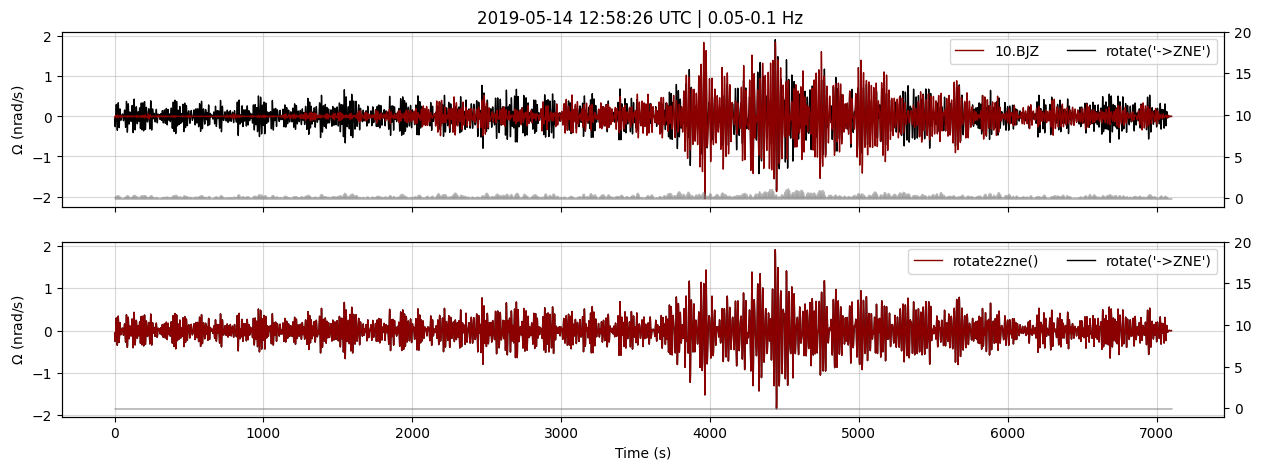

In [19]:
config['fmin'] = 0.05
config['fmax'] = 0.1

st1 = st_all.copy()
st1 = st1.detrend("demean");
st1 = st1.taper(0.01);
st1 = st1.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);
st1 = st1.trim(config['tbeg']+100, config['tend'])

st2 = stx.copy()
st2 = st2.detrend("demean");
st2 = st2.taper(0.01);
st2 = st2.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);
st2 = st2.trim(config['tbeg']+100, config['tend'])


fig = __makeplot_waveform_comparison3(st1, st2)


In [123]:
def __smooth(y, npts, win="hanning", setpad=True):

    from numpy import ones, convolve, hanning, nan, pad

    if win == "hanning":
        win = hanning(npts)
    elif win == "boxcar":
        win = ones(npts)

    if setpad:
        y = pad(y, npts, mode="edge")

    y_smooth = convolve(y, win/sum(win), mode='same')

    if setpad:
        y_smooth = y_smooth[npts:-npts]

    return y_smooth

In [230]:
from functions.smoothing import __smooth
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.get_fband_average import __get_fband_average
from numpy import log10

psds, psds_smth = [], []
comp = ["Z", "U", "V", "W"]
ff, ffsmth = [], []

for i in comp:

    dt = st[0].stats.delta

    f, psd = __multitaper_psd(st.select(channel=f"*{i}")[0].data, dt, n_win=15, time_bandwidth=3.5)
    # f, psd = __welch_psd(st.select(channel=f"*{i}")[0].data, dt, twin_sec=3600)

    psd = 10*log10(psd)

    psds.append(psd)
    ff.append(f)

    # psds_smth.append(__smooth(psd, 50))
    # ffsmth.append(f)

    out = __get_fband_average(f, psd, faction_of_octave=12, average='mean', plot=False)

    psds_smth.append(out['psd_means'])
    ffsmth.append(out['fcenter'])



# add Z rotated
        
f, psd = __multitaper_psd(stx.select(channel=f"*Z")[0].data, dt, n_win=15, time_bandwidth=3.5)
# f, psd = __welch_psd(stx.select(channel=f"*Z")[0].data, dt, twin_sec=3600)

psd = 10*log10(psd)

psds.append(psd)
ff.append(f)

# psds_smth.append(__smooth(psd, 50))
# ffsmth.append(f)

out = __get_fband_average(f, psd, faction_of_octave=12, average='mean', plot=False)

psds_smth.append(out['psd_means'])
ffsmth.append(out['fcenter'])
    


comp.append("Z'")

DPSS using interpolation 144041 100000
DPSS using interpolation 144041 100000
DPSS using interpolation 144041 100000
DPSS using interpolation 144041 100000
DPSS using interpolation 144041 100000


## Plotting

144042 144042
144042 144042
144042 144042
144042 144042
144042 144042


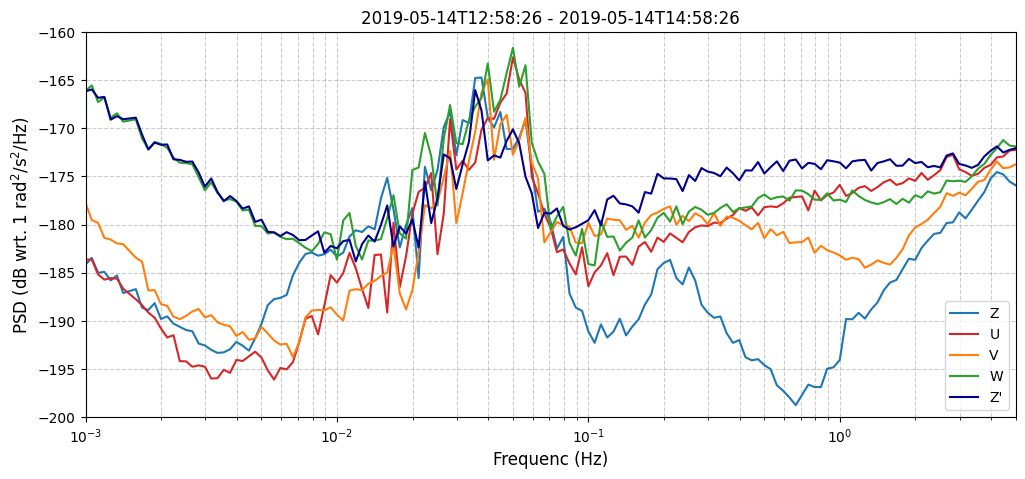

In [231]:
def __makeplot():

    from numpy import log10

    font = 12
    
    plt.figure(figsize=(12, 5))

    
    cols = ["tab:blue", "tab:red", "tab:orange", "tab:green", "darkblue"]
    
    for i, (f, fs, psd, psd_smth, c) in enumerate(zip(ff, ffsmth, psds, psds_smth, comp)):

        N = abs(f[f>0.04].size - f.size)
        Ns = abs(fs[fs>0.04].size - fs.size)

        print(len(f), len(psd))
        # plt.plot(f[:N], psd[:N], label=c, color=cols[i])
        # plt.plot(f[N:], psd[N:], color=cols[i], alpha=0.3)
        # plt.plot(fs[Ns:], psd_smth[Ns:], color=cols[i])
        plt.plot(fs, psd_smth, color=cols[i], label=c)

    plt.xlabel("Frequenc (Hz)", fontsize=font)
    plt.ylabel("PSD (dB wrt. 1 rad$^2$/s$^2$/Hz)", fontsize=font)

    # plt.yscale("log")
    plt.xscale("log")
    
    plt.title(f"{str(config['tbeg'])[:19]} - {str(config['tend'])[:19]}")
    
    plt.grid(ls="--", color="gray", alpha=0.4, which="both")

    plt.ylim(-200, -160)
    plt.xlim(1e-3, 5e0)

    plt.legend()
    plt.show();

    return fig

fig = __makeplot()

fig.savefig(config['path_to_figs']+"Spectra_rotation_comparison.png", format="png", dpi=150, bbox_inches='tight')
